In [3]:
! tar -xzf _dataset/dataset.tar.gz

# This notebook generates synthetic data

## Import packages and functions

In [4]:
import os
import json
import cv2
import numpy as np
import yaml
import random
import matplotlib.pyplot as plt

In [5]:
from utils import utils

In [6]:
TMP_LABEL = "/tmp/ls-label.txt"
UTILS_DIR_PATH = "utils/"
LABELS_INFO = UTILS_DIR_PATH + "labels.json"
DATASET_PATH = "dataset/"
DATA_CONFIG_PATH = "utils/data.yaml"

NB_FRAMES_PER_VIDEO = 5

In [7]:
def generate_dirs():
    os.makedirs(DATASET_PATH, exist_ok = True)
    os.makedirs(DATASET_PATH + "labels/train", exist_ok = True)
    os.makedirs(DATASET_PATH + "labels/test", exist_ok = True)
    os.makedirs(DATASET_PATH + "labels/val", exist_ok = True)
    os.makedirs(DATASET_PATH + "images/train", exist_ok = True)
    os.makedirs(DATASET_PATH + "images/test", exist_ok = True)
    os.makedirs(DATASET_PATH + "images/val", exist_ok = True)

## Visualize the traffic. The background is transparent.

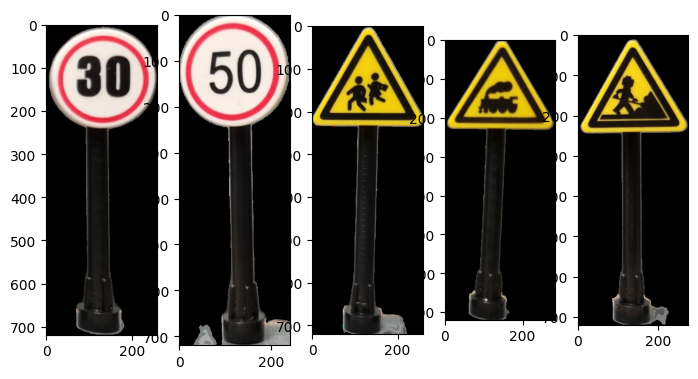

In [8]:
files = [e for e in os.listdir("utils/images") if "lego" in e]
fig = plt.figure(figsize=(10, 7)) 
rows, columns = 1, 6
for i, file in enumerate(files):
    fig.add_subplot(rows, columns, i+1)
    image = cv2.imread("utils/images/"+file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

## Generate synthetic data

In [9]:
generate_dirs()
with open(LABELS_INFO) as f:
    label_info = json.load(f)

video_path = UTILS_DIR_PATH + "video/video1.mp4"
random_frames = utils.extract_random_frames(video_path, NB_FRAMES_PER_VIDEO)
nb_frames = len(random_frames)

# Iterate on random frames from the video
for i, frame in enumerate(random_frames):
    frame_height, frame_width, _ = frame.shape
    for label in label_info.keys():
        label_id = label_info[label]["label_id"]
        for traffic_sign_info in label_info[label]["children"].values():
            # Insert traffic sign onto frame
            # All possible traffic signs are stored in the utils folder
            image_path = UTILS_DIR_PATH + traffic_sign_info["path"]
            bbox_size = (int(traffic_sign_info["bbox_w"]), int(traffic_sign_info["bbox_h"]))
            inserted_image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            if inserted_image is None:
                raise Exception("Error: Couldn't load the inserted image file.")
            frame_copy = frame.copy()
            frame_copy, coordinates = utils.insert_image(frame_copy, inserted_image, frame_width, frame_height, bbox_size)
            
            # Save labels and images in yolo format
            yolo_format = utils.to_yolo_format(frame_width, frame_height, coordinates)
            split = utils.determine_split(i, nb_frames)
            utils.add_to_yolo_dataset(frame_copy, split, label_id, label, yolo_format, DATASET_PATH)

## Visualize some results

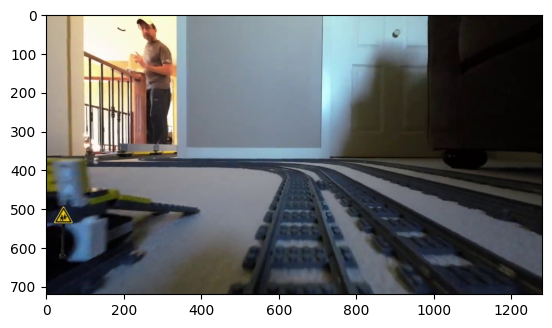

In [10]:
file = random.choice([ f for f in os.listdir("dataset/images/train") if any(match_name in f for match_name in ["SpeedLimit", "DangerAhead"]) ])
image = cv2.imread("dataset/images/train/"+file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);

In [11]:
! tar -czf dataset-full.tar.gz dataset